In [ ]:
! git clone https://github.com/jhonatansossa/deep-learning-project-JS.git

### Dependencias

In [4]:
import sys
sys.path.append('/content/deep-learning-project-JS/notebooks')

In [5]:
import pandas as pd
import numpy as np
from utils import dataframe_helpers as df_helpers
import seaborn as sns

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt

### Importar datos limpios

In [6]:
df_master = pd.read_parquet(r'/content/deep-learning-project-JS/data/02_intermediate/cleaned_train.parquet.snappy', engine='pyarrow')
df_transactions = pd.read_parquet(r'/content/deep-learning-project-JS/data/02_intermediate/cleaned_transactions.parquet.snappy', engine='pyarrow')
df_stores = pd.read_parquet(r'/content/deep-learning-project-JS/data/02_intermediate/cleaned_stores.parquet.snappy', engine='pyarrow')
df_oil = pd.read_parquet(r'/content/deep-learning-project-JS/data/02_intermediate/cleaned_oil.parquet.snappy', engine='pyarrow')
df_holidays_events = pd.read_parquet(r'/content/deep-learning-project-JS/02_intermediate/cleaned_holidays_events.parquet.snappy', engine='pyarrow')

### Agregación de los datos

In [7]:
df_maestro_agregado = df_master.groupby([pd.Grouper(key='date', freq='W'), 'store_nbr', 'family'])['sales', 'onpromotion'].sum().reset_index()
for i in range(1, 5, 1):
    df_maestro_agregado['rezago_onpromotion_'+str(i)] = df_maestro_agregado.sort_values(by=['family', 'store_nbr', 'date']).groupby(['family', 'store_nbr'])['onpromotion'].shift(i)
df_maestro_agregado = df_maestro_agregado.dropna()
df_maestro_agregado

<ipython-input-7-3253467a18c8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_maestro_agregado = df_master.groupby([pd.Grouper(key='date', freq='W'), 'store_nbr', 'family'])['sales', 'onpromotion'].sum().reset_index()


,date,store_nbr,family,sales,onpromotion,rezago_onpromotion_1,rezago_onpromotion_2,rezago_onpromotion_3,rezago_onpromotion_4
7128,2013-02-03,1,automotive,14.000000,0,0.0,0.0,0.0,0.0
7129,2013-02-03,1,baby care,0.000000,0,0.0,0.0,0.0,0.0
7130,2013-02-03,1,beauty,15.000000,0,0.0,0.0,0.0,0.0
7131,2013-02-03,1,beverages,6012.000000,0,0.0,0.0,0.0,0.0
7132,2013-02-03,1,books,0.000000,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
429457,2017-08-13,54,poultry,486.995996,10,8.0,9.0,9.0,11.0
429458,2017-08-13,54,prepared foods,543.000000,0,0.0,1.0,0.0,0.0
429459,2017-08-13,54,produce,4620.846000,91,97.0,118.0,163.0,175.0
429460,2017-08-13,54,school and office supplies,0.000000,0,0.0,0.0,0.0,0.0


#### Agregar la información de la tienda a la maestra SEMANAL

In [8]:
df_maestro_agregado = df_maestro_agregado.set_index('store_nbr').join(df_stores.set_index('store_nbr'), on='store_nbr',how='left').reset_index()
df_maestro_agregado

,store_nbr,date,family,sales,onpromotion,rezago_onpromotion_1,rezago_onpromotion_2,rezago_onpromotion_3,rezago_onpromotion_4,city,state,type,cluster
0,1,2013-02-03,automotive,14.000000,0,0.0,0.0,0.0,0.0,quito,pichincha,d,13
1,1,2013-02-03,baby care,0.000000,0,0.0,0.0,0.0,0.0,quito,pichincha,d,13
2,1,2013-02-03,beauty,15.000000,0,0.0,0.0,0.0,0.0,quito,pichincha,d,13
3,1,2013-02-03,beverages,6012.000000,0,0.0,0.0,0.0,0.0,quito,pichincha,d,13
4,1,2013-02-03,books,0.000000,0,0.0,0.0,0.0,0.0,quito,pichincha,d,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
422329,54,2017-08-13,poultry,486.995996,10,8.0,9.0,9.0,11.0,el carmen,manabi,c,3
422330,54,2017-08-13,prepared foods,543.000000,0,0.0,1.0,0.0,0.0,el carmen,manabi,c,3
422331,54,2017-08-13,produce,4620.846000,91,97.0,118.0,163.0,175.0,el carmen,manabi,c,3
422332,54,2017-08-13,school and office supplies,0.000000,0,0.0,0.0,0.0,0.0,el carmen,manabi,c,3


# Agregar la información del precio del pretroleo por SEMANA

In [9]:
df_oil_ = df_oil.copy(deep = True)
df_oil_['date'] = pd.to_datetime(df_oil_['date'])
df_oil_.set_index('date',inplace = True)
df_oil_ = df_oil_.resample('W').mean()
for i in range(1, 5, 1):
    df_oil_['rezago_oil_'+str(i)] = df_oil_['dcoilwtico'].shift(i)
df_oil_ = df_oil_.dropna()
df_oil_

,dcoilwtico,rezago_oil_1,rezago_oil_2,rezago_oil_3,rezago_oil_4
date,,,,,
2013-02-03,97.332,95.4125,94.5820,93.3800,93.076667
2013-02-10,96.176,97.3320,95.4125,94.5820,93.380000
2013-02-17,96.954,96.1760,97.3320,95.4125,94.582000
2013-02-24,94.380,96.9540,96.1760,97.3320,95.412500
2013-03-03,92.190,94.3800,96.9540,96.1760,97.332000
...,...,...,...,...,...
2017-08-06,49.520,48.2660,46.4060,45.5060,44.960000
2017-08-13,49.076,49.5200,48.2660,46.4060,45.506000
2017-08-20,47.524,49.0760,49.5200,48.2660,46.406000


In [10]:
df_maestro_agregado = df_maestro_agregado.set_index('date').join(df_oil_, on='date', how='left')
df_maestro_agregado

,store_nbr,family,sales,onpromotion,rezago_onpromotion_1,rezago_onpromotion_2,rezago_onpromotion_3,rezago_onpromotion_4,city,state,type,cluster,dcoilwtico,rezago_oil_1,rezago_oil_2,rezago_oil_3,rezago_oil_4
date,,,,,,,,,,,,,,,,,
2013-02-03,1,automotive,14.000000,0,0.0,0.0,0.0,0.0,quito,pichincha,d,13,97.332,95.4125,94.582,93.380,93.076667
2013-02-03,1,baby care,0.000000,0,0.0,0.0,0.0,0.0,quito,pichincha,d,13,97.332,95.4125,94.582,93.380,93.076667
2013-02-03,1,beauty,15.000000,0,0.0,0.0,0.0,0.0,quito,pichincha,d,13,97.332,95.4125,94.582,93.380,93.076667
2013-02-03,1,beverages,6012.000000,0,0.0,0.0,0.0,0.0,quito,pichincha,d,13,97.332,95.4125,94.582,93.380,93.076667
2013-02-03,1,books,0.000000,0,0.0,0.0,0.0,0.0,quito,pichincha,d,13,97.332,95.4125,94.582,93.380,93.076667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-13,54,poultry,486.995996,10,8.0,9.0,9.0,11.0,el carmen,manabi,c,3,49.076,49.5200,48.266,46.406,45.506000
2017-08-13,54,prepared foods,543.000000,0,0.0,1.0,0.0,0.0,el carmen,manabi,c,3,49.076,49.5200,48.266,46.406,45.506000
2017-08-13,54,produce,4620.846000,91,97.0,118.0,163.0,175.0,el carmen,manabi,c,3,49.076,49.5200,48.266,46.406,45.506000


#### Agregar información del número de festivos en la SEMANA

In [11]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,holiday,local,manta,fundacion de manta,False
1,2012-04-01,holiday,regional,cotopaxi,provincializacion de cotopaxi,False
2,2012-04-12,holiday,local,cuenca,fundacion de cuenca,False
3,2012-04-14,holiday,local,libertad,cantonizacion de libertad,False
4,2012-04-21,holiday,local,riobamba,cantonizacion de riobamba,False


In [12]:
df_holidays_events = df_holidays_events.loc[(df_holidays_events["transferred"] == False)]

Cambiar la fecha por el último día de la semana para luego pivotear

In [13]:
from pandas.tseries.offsets import *
df_holidays_events['date'] = df_holidays_events['date'].where( df_holidays_events['date'] == (( df_holidays_events['date'] + Week(weekday=6) ) - Week()), df_holidays_events['date'] + Week(weekday=6))
df_holidays_events

<ipython-input-13-f51e5fedf0e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_holidays_events['date'] = df_holidays_events['date'].where( df_holidays_events['date'] == (( df_holidays_events['date'] + Week(weekday=6) ) - Week()), df_holidays_events['date'] + Week(weekday=6))


,date,type,locale,locale_name,description,transferred
0,2012-03-04,holiday,local,manta,fundacion de manta,False
1,2012-04-01,holiday,regional,cotopaxi,provincializacion de cotopaxi,False
2,2012-04-15,holiday,local,cuenca,fundacion de cuenca,False
3,2012-04-15,holiday,local,libertad,cantonizacion de libertad,False
4,2012-04-22,holiday,local,riobamba,cantonizacion de riobamba,False
...,...,...,...,...,...,...
345,2017-12-24,additional,national,ecuador,navidad-3,False
346,2017-12-24,additional,national,ecuador,navidad-2,False
347,2017-12-24,additional,national,ecuador,navidad-1,False
348,2017-12-31,holiday,national,ecuador,navidad,False


Agrupando por fecha, tipo de festivo, la localización y el nombre de la localización

In [14]:
df_holidays_events_agrupado = df_holidays_events.groupby([pd.Grouper(key='date', freq='W'), 'type', 'locale', 'locale_name']).agg({'transferred': 'count'}).reset_index()
df_holidays_events_agrupado

,date,type,locale,locale_name,transferred
0,2012-03-04,holiday,local,manta,1
1,2012-04-01,holiday,regional,cotopaxi,1
2,2012-04-15,holiday,local,cuenca,1
3,2012-04-15,holiday,local,libertad,1
4,2012-04-22,holiday,local,riobamba,1
...,...,...,...,...,...
265,2017-12-10,transfer,local,quito,1
266,2017-12-24,additional,national,ecuador,4
267,2017-12-24,holiday,local,salinas,1
268,2017-12-31,additional,national,ecuador,1


Pivoteando por tipo de festivo, localización y nombre de localización

In [15]:
df_holidays_events_pivoteado = df_holidays_events_agrupado.pivot(index='date', columns=['type', 'locale', 'locale_name'], values='transferred').fillna(0)
df_holidays_events_pivoteado

type        holiday                                                            \
locale        local regional  local                                             
locale_name   manta cotopaxi cuenca libertad riobamba puyo guaranda latacunga   
date                                                                            
2012-03-04      1.0      0.0    0.0      0.0      0.0  0.0      0.0       0.0   
2012-04-01      0.0      1.0    0.0      0.0      0.0  0.0      0.0       0.0   
2012-04-15      0.0      0.0    1.0      1.0      0.0  0.0      0.0       0.0   
2012-04-22      0.0      0.0    0.0      0.0      1.0  0.0      0.0       0.0   
2012-05-13      0.0      0.0    0.0      0.0      0.0  1.0      0.0       0.0   
...             ...      ...    ...      ...      ...  ...      ...       ...   
2017-11-05      0.0      0.0    0.0      0.0      0.0  0.0      0.0       0.0   
2017-11-12      0.0      0.0    0.0      0.0      0.0  0.0      1.0       1.0   
2017-12-10      0.0      0.0    0.0      0.0      0.0  0.0      0.0       0.0   
2017-12-24      0.0      0.0    0.0      0.0      0.0  0.0      0.0       0.0   
2017-12-31      0.0      0.0    0.0      0.0      0.0  0.0      0.0       0.0   

type                          ...           bridge work day    event  \
locale              regional  ...   local national national national   
locale_name machala imbabura  ... salinas  ecuador  ecuador  ecuador   
date                          ...                                      
2012-03-04      0.0      0.0  ...     0.0      0.0      0.0      0.0   
2012-04-01      0.0      0.0  ...     0.0      0.0      0.0      0.0   
2012-04-15      0.0      0.0  ...     0.0      0.0      0.0      0.0   
2012-04-22      0.0      0.0  ...     0.0      0.0      0.0      0.0   
2012-05-13      0.0      0.0  ...     0.0      0.0      0.0      0.0   
...             ...      ...  ...     ...      ...      ...      ...   
2017-11-05      0.0      0.0  ...     0.0      0.0      0.0      0.0   
2017-11-12      0.0      0.0  ...     0.0      0.0      0.0      0.0   
2017-12-10      0.0      0.0  ...     0.0      0.0      0.0      0.0   
2017-12-24      0.0      0.0  ...     1.0      0.0      0.0      0.0   
2017-12-31      0.0      0.0  ...     0.0      0.0      0.0      0.0   

type        additional   holiday  transfer                      
locale           local     local     local                      
locale_name  guayaquil guayaquil guayaquil cuenca ibarra quito  
date                                                            
2012-03-04         0.0       0.0       0.0    0.0    0.0   0.0  
2012-04-01         0.0       0.0       0.0    0.0    0.0   0.0  
2012-04-15         0.0       0.0       0.0    0.0    0.0   0.0  
2012-04-22         0.0       0.0       0.0    0.0    0.0   0.0  
2012-05-13         0.0       0.0       0.0    0.0    0.0   0.0  
...                ...       ...       ...    ...    ...   ...  
2017-11-05         0.0       0.0       0.0    0.0    0.0   0.0  
2017-11-12         0.0       0.0       0.0    0.0    0.0   0.0  
2017-12-10         0.0       0.0       0.0    0.0    0.0   1.0  
2017-12-24         0.0       0.0       0.0    0.0    0.0   0.0  
2017-12-31         0.0       0.0       0.0    0.0    0.0   0.0  

[155 rows x 35 columns]

In [16]:
df_maestro_agregado = df_maestro_agregado.join(df_holidays_events_pivoteado, on='date', how='left').reset_index()
df_maestro_agregado = df_maestro_agregado.fillna(0)
df_maestro_agregado

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:9130: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,3 on the right)
  return merge(


,date,store_nbr,family,sales,onpromotion,rezago_onpromotion_1,rezago_onpromotion_2,rezago_onpromotion_3,rezago_onpromotion_4,city,...,"(holiday, local, salinas)","(bridge, national, ecuador)","(work day, national, ecuador)","(event, national, ecuador)","(additional, local, guayaquil)","(holiday, local, guayaquil)","(transfer, local, guayaquil)","(transfer, local, cuenca)","(transfer, local, ibarra)","(transfer, local, quito)"
0,2013-02-03,1,automotive,14.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-02-03,1,baby care,0.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-02-03,1,beauty,15.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-02-03,1,beverages,6012.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-02-03,1,books,0.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422329,2017-08-13,54,poultry,486.995996,10,8.0,9.0,9.0,11.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
422330,2017-08-13,54,prepared foods,543.000000,0,0.0,1.0,0.0,0.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
422331,2017-08-13,54,produce,4620.846000,91,97.0,118.0,163.0,175.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
422332,2017-08-13,54,school and office supplies,0.000000,0,0.0,0.0,0.0,0.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Limpiando el nombre de las columnas

In [17]:
df_maestro_agregado.columns = [df_helpers.clean_column_name(c) for c in df_maestro_agregado.columns]
df_maestro_agregado

,date,store_nbr,family,sales,onpromotion,rezago_onpromotion_1,rezago_onpromotion_2,rezago_onpromotion_3,rezago_onpromotion_4,city,...,holiday_local_salinas,bridge_national_ecuador,work_day_national_ecuador,event_national_ecuador,additional_local_guayaquil,holiday_local_guayaquil,transfer_local_guayaquil,transfer_local_cuenca,transfer_local_ibarra,transfer_local_quito
0,2013-02-03,1,automotive,14.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-02-03,1,baby care,0.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-02-03,1,beauty,15.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-02-03,1,beverages,6012.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-02-03,1,books,0.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422329,2017-08-13,54,poultry,486.995996,10,8.0,9.0,9.0,11.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
422330,2017-08-13,54,prepared foods,543.000000,0,0.0,1.0,0.0,0.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
422331,2017-08-13,54,produce,4620.846000,91,97.0,118.0,163.0,175.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
422332,2017-08-13,54,school and office supplies,0.000000,0,0.0,0.0,0.0,0.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Time series Analysis

In [18]:
df1 = df_maestro_agregado.copy(deep = True)
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date',inplace = True)
df1 = df1.resample('W').sum()

In [19]:
l3 = list(df1.columns)
l3.remove('sales')

df1.drop(columns = l3,inplace =True)
df1.head()

,sales
date,
2013-02-03,2.476891e+06
2013-02-10,2.342470e+06
2013-02-17,2.420609e+06
2013-02-24,2.377201e+06
2013-03-03,2.630630e+06


Funciones de apoyo para el análisis de series temporales

In [20]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window = 12).mean()
    MSTD = timeseries.rolling(window = 12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [21]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

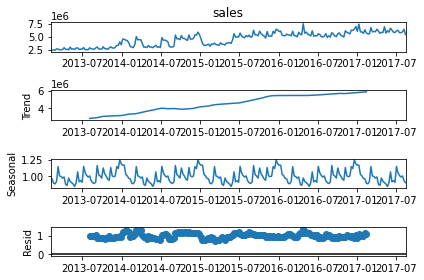

In [22]:
dec = sm.tsa.seasonal_decompose(df1['sales'], model = 'multiplicative').plot()
plt.show();



*   Los datos tienen una tendencia alcista no lineal
*   Los datos tienen un claro patron estacional

Para poder realizar un pronóstico, se debe asegurar de que los componentes anteriores son eliminados de la serie temporal



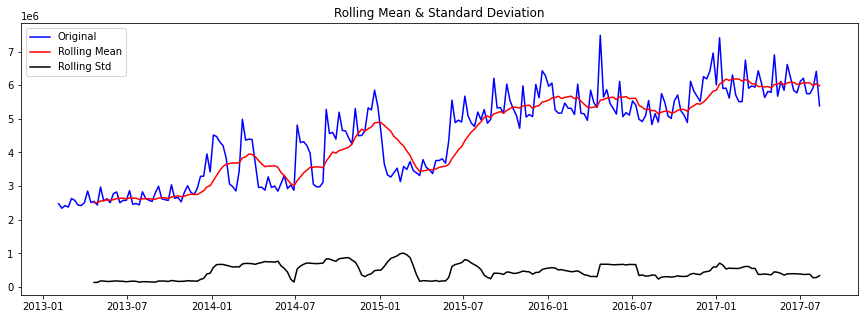

Results of Dickey-Fuller Test:
Test Statistic                  -1.449009
p-value                          0.558568
#Lags Used                      13.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


In [23]:
test_stationarity(df1['sales'])



*   La estacionariedad de una serie de tiempo se define cuando los parámetros estadísticos como la media, varianza, desviación estandar, etc, no cambian con el tiempo.
*   Si la serie temporal es no estacionaria, entonces los pronósticos se desvían de los valores originales y aumentan el error ya que se desconocen los cambios de los parámetos estadísticos en función del tiempo.
*   De acuerdo con la gráfica anterior, la media móvil de la serie temporal cambia considerablemente con respecto al tiempo, lo que indica que la serie no es estacionaria.
*   La desviación estándar móvil confirma lo anterior, pues a lo largo del tiempo se observan variaciones en su magnitud.
*   Dos criterios para confirmar la estacionariedad de una serie temporal es estacionaria son los siguientes:
        1.   Critial Value (5%) > Test Statistic
        2.   p-value < 0.05

De acuerdo a los resultados anteriores también se confirma que la serie es no estacionaria ya que ninguno de los criterios se cumple.



A continuación entonces se utilizará diferenciación (restar el valor anterior del valor siguiente) para eliminar la tendencia, la estacionalidad y hacer que la serie sea estacionaria.

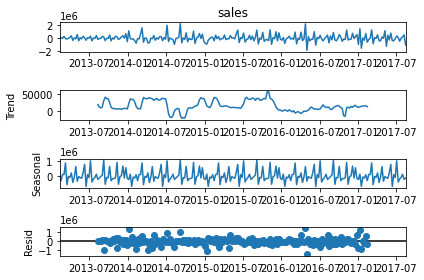

In [24]:
#df1['Log_sales'] = np.log(df1['sales'])
df1_diff = df1['sales'].diff()
df1_diff = df1_diff.dropna()

dec = sm.tsa.seasonal_decompose(df1_diff,period = 52).plot()
plt.show()


En la gráfica anterior se observa que se han eliminado la tendencia y la estacionalidad de la serie casi por completo






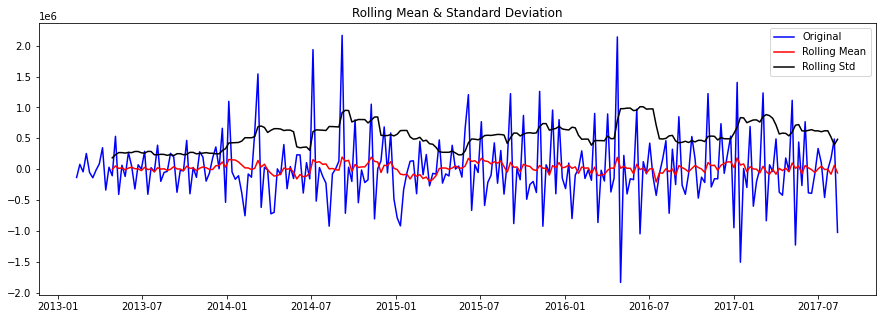

Results of Dickey-Fuller Test:
Test Statistic                  -4.680148
p-value                          0.000092
#Lags Used                      15.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


In [25]:
test_stationarity(df1_diff)

De lo anterior se concluye que:


*   La media móvil de la serie temporal no ha desaparecido pero sí conserva variaciones muy pequeñas (casi despreciables)
*   La deviación móvil ha disminuído su magnitud de variación casi al 20%.
*   Critical Value (5%): -2.87 > Test Statistic: -4.68. 
*   0.05 > p-value (0.00)

Por lo tanto, la serie temporal es ahora cuasi-estacionaria


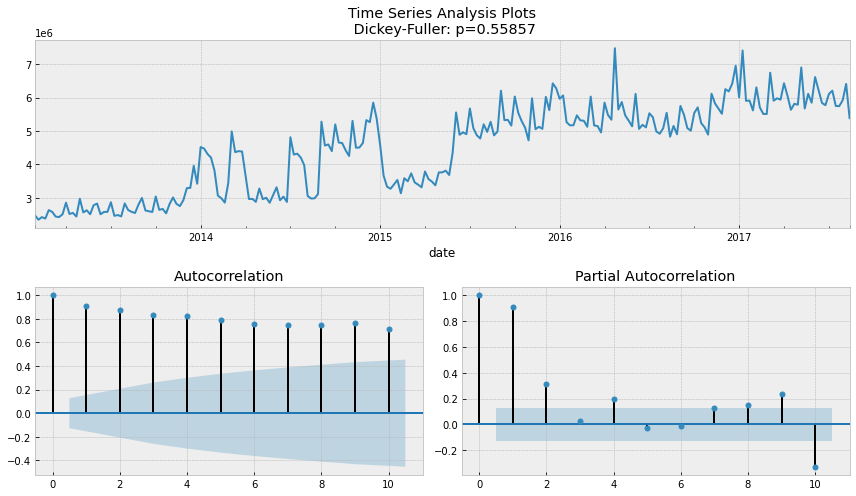

In [26]:
tsplot(df1['sales'],lags = 10)

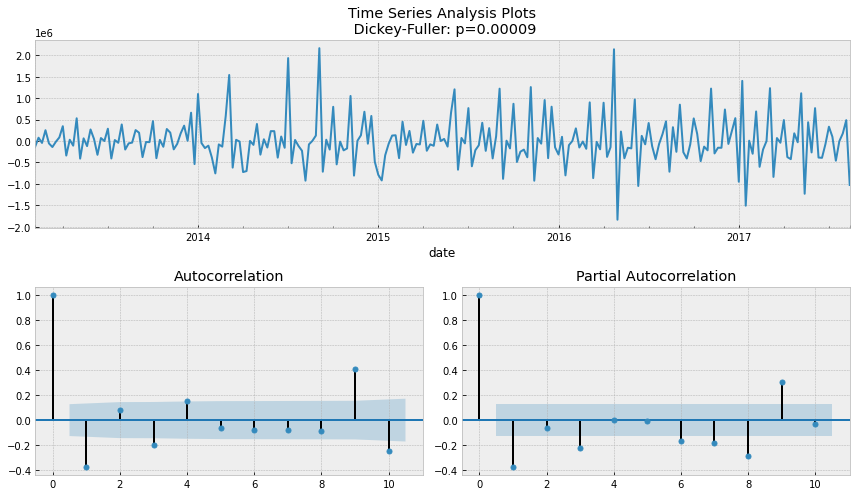

In [27]:
tsplot(df1_diff,lags = 10)

#### Reemplazando la serie cuasi-estacionaria

In [28]:
#df_maestro_agregado['Log_sales_diff'] = np.log(df_maestro_agregado['sales'])
df_maestro_agregado['diff_sales'] = df_maestro_agregado.sort_values(by=['family', 'store_nbr', 'date']).groupby(['family', 'store_nbr'])['sales'].diff()
df_maestro_agregado = df_maestro_agregado.dropna()

df_maestro_agregado

,date,store_nbr,family,sales,onpromotion,rezago_onpromotion_1,rezago_onpromotion_2,rezago_onpromotion_3,rezago_onpromotion_4,city,...,bridge_national_ecuador,work_day_national_ecuador,event_national_ecuador,additional_local_guayaquil,holiday_local_guayaquil,transfer_local_guayaquil,transfer_local_cuenca,transfer_local_ibarra,transfer_local_quito,diff_sales
1782,2013-02-10,1,automotive,14.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
1783,2013-02-10,1,baby care,0.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
1784,2013-02-10,1,beauty,13.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.000
1785,2013-02-10,1,beverages,5203.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-809.000
1786,2013-02-10,1,books,0.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422329,2017-08-13,54,poultry,486.995996,10,8.0,9.0,9.0,11.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.841
422330,2017-08-13,54,prepared foods,543.000000,0,0.0,1.0,0.0,0.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-113.000
422331,2017-08-13,54,produce,4620.846000,91,97.0,118.0,163.0,175.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-242.309
422332,2017-08-13,54,school and office supplies,0.000000,0,0.0,0.0,0.0,0.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000


Agregar rezagos de la diferencia

In [29]:
for i in range(1, 5, 1):
    df_maestro_agregado['rezago_diff_sales_'+str(i)] = df_maestro_agregado.sort_values(by=['family', 'store_nbr', 'date']).groupby(['family', 'store_nbr'])['diff_sales'].shift(i)
df_maestro_agregado = df_maestro_agregado.dropna()
df_maestro_agregado

<ipython-input-29-2edd2dea0799>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_maestro_agregado['rezago_diff_sales_'+str(i)] = df_maestro_agregado.sort_values(by=['family', 'store_nbr', 'date']).groupby(['family', 'store_nbr'])['diff_sales'].shift(i)


,date,store_nbr,family,sales,onpromotion,rezago_onpromotion_1,rezago_onpromotion_2,rezago_onpromotion_3,rezago_onpromotion_4,city,...,holiday_local_guayaquil,transfer_local_guayaquil,transfer_local_cuenca,transfer_local_ibarra,transfer_local_quito,diff_sales,rezago_diff_sales_1,rezago_diff_sales_2,rezago_diff_sales_3,rezago_diff_sales_4
8910,2013-03-10,1,automotive,7.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,-2.000,-6.000,13.000000,-12.000000,0.000
8911,2013-03-10,1,baby care,0.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000
8912,2013-03-10,1,beauty,12.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,2.000,-2.000,5.000000,-6.000000,-2.000
8913,2013-03-10,1,beverages,6803.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,739.000,89.000,1779.000000,-1007.000000,-809.000
8914,2013-03-10,1,books,0.000000,0,0.0,0.0,0.0,0.0,quito,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422329,2017-08-13,54,poultry,486.995996,10,8.0,9.0,9.0,11.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.841,95.470,-155.629009,23.154007,50.598
422330,2017-08-13,54,prepared foods,543.000000,0,0.0,1.0,0.0,0.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,-113.000,52.000,-59.000000,169.000000,-113.000
422331,2017-08-13,54,produce,4620.846000,91,97.0,118.0,163.0,175.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,-242.309,128.031,-114.313000,78.105000,-168.845
422332,2017-08-13,54,school and office supplies,0.000000,0,0.0,0.0,0.0,0.0,el carmen,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000


#### Comprobando que las combinaciones familia - punto de venta sean estacionarias por sí mismas

In [30]:
family = 'beverages'
store_nbr = 40
family_store = df_maestro_agregado.loc[(df_maestro_agregado['family'] == family) & (df_maestro_agregado['store_nbr'] == store_nbr)]['diff_sales']

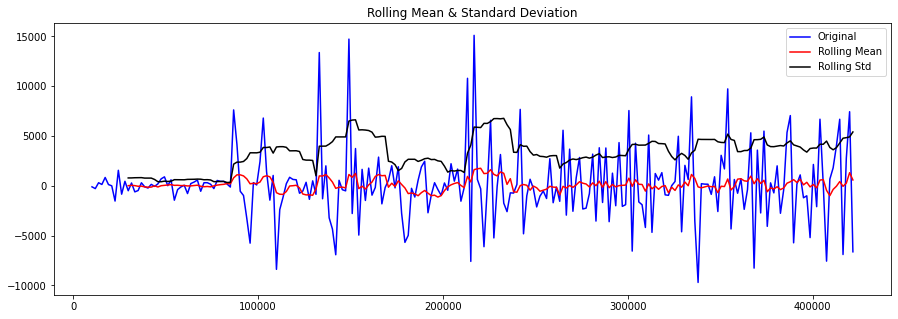

Results of Dickey-Fuller Test:
Test Statistic                -5.941160e+00
p-value                        2.259272e-07
#Lags Used                     8.000000e+00
Number of Observations Used    2.230000e+02
Critical Value (1%)           -3.460019e+00
Critical Value (5%)           -2.874590e+00
Critical Value (10%)          -2.573725e+00
dtype: float64


In [31]:
test_stationarity(family_store)

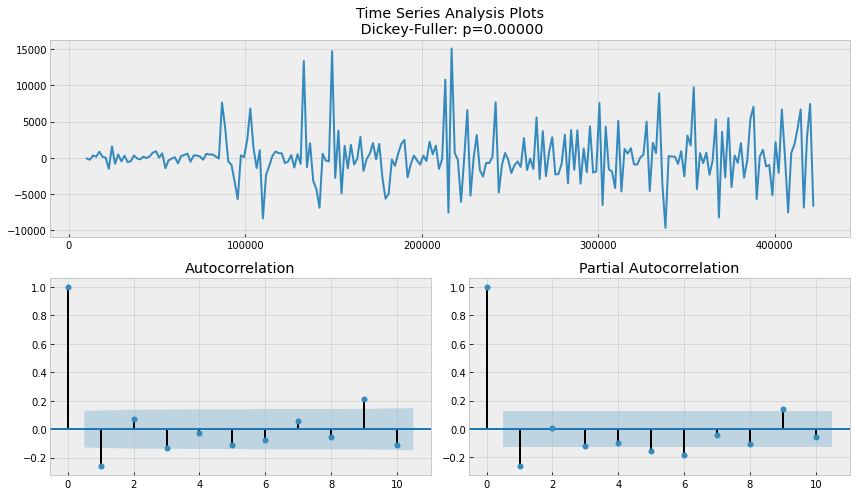

In [32]:
tsplot(family_store,lags = 10)

#### Guardando el maestro en el lago de datos

In [33]:
df_maestro_agregado.to_parquet(r'/content/deep-learning-project-JS/data/03_primary/aggregated_master.parquet.snappy', compression='snappy')  